# CIC-IDS-2017 Intrusion Detection Pipeline

A unified, production-ready multi-class classification pipeline for network intrusion detection using the CIC-IDS-2017 dataset.

## Features
- **Multi-class classification**: BENIGN vs all 14 attack types in a single model
- **Robust preprocessing**: Handles missing values, infinities, and collinear features
- **Class-weighted training**: Addresses severe class imbalance without aggressive undersampling
- **Comprehensive evaluation**: Per-class precision/recall/F1, confusion matrix, ROC-AUC
- **Reproducible**: Fixed random seeds throughout

---

## 1. Imports and Configuration

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import warnings
import os
import joblib
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Model selection and evaluation
from sklearn.model_selection import (
    train_test_split, 
    StratifiedKFold, 
    RandomizedSearchCV,
    cross_val_score
)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay
)

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# Suppress warnings for cleaner output during development
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Configuration
CONFIG = {
    'data_dir': 'dataset',
    'output_dir': 'outputs',
    'n_features': 30,
    'test_size': 0.15,
    'val_size': 0.15,
    'cv_folds': 3,       # Reduced from 5
    'n_iter_search': 5,   # Reduced from 20
}

# Create output directory
os.makedirs(CONFIG['output_dir'], exist_ok=True)

print("Configuration loaded successfully.")
print(f"Random state: {RANDOM_STATE}")
print(f"Feature selection target: {CONFIG['n_features']} features")

Configuration loaded successfully.
Random state: 42
Feature selection target: 30 features


## 2. Data Loading

Load all CIC-IDS-2017 CSV files from the `dataset/` folder and combine into a single DataFrame.

In [2]:
def load_cicids_data(data_dir):
    """
    Load all CIC-IDS-2017 CSV files from the specified directory.
    
    Parameters:
    -----------
    data_dir : str
        Path to directory containing CSV files
        
    Returns:
    --------
    pd.DataFrame
        Combined DataFrame with all data and a 'Source_File' column
    """
    csv_files = list(Path(data_dir).glob('*.csv'))
    
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in {data_dir}")
    
    print(f"Found {len(csv_files)} CSV files:")
    for f in csv_files:
        print(f"  - {f.name}")
    
    dfs = []
    for csv_file in csv_files:
        print(f"\nLoading {csv_file.name}...", end=" ")
        df = pd.read_csv(csv_file, encoding='iso-8859-1', low_memory=False)
        df.columns = df.columns.str.strip()  # Clean column names
        df['Source_File'] = csv_file.stem  # Track source for potential time-based splits
        print(f"{len(df):,} rows")
        dfs.append(df)
    
    combined_df = pd.concat(dfs, ignore_index=True)
    print(f"\n{'='*50}")
    print(f"Total rows: {len(combined_df):,}")
    print(f"Total columns: {len(combined_df.columns)}")
    
    return combined_df

# Load the data
df = load_cicids_data(CONFIG['data_dir'])

Found 8 CSV files:
  - Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
  - Monday-WorkingHours.pcap_ISCX.csv
  - Friday-WorkingHours-Morning.pcap_ISCX.csv
  - Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
  - Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
  - Tuesday-WorkingHours.pcap_ISCX.csv
  - Wednesday-workingHours.pcap_ISCX.csv
  - Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv

Loading Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv... 288,602 rows

Loading Monday-WorkingHours.pcap_ISCX.csv... 529,918 rows

Loading Friday-WorkingHours-Morning.pcap_ISCX.csv... 191,033 rows

Loading Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv... 286,467 rows

Loading Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv... 225,745 rows

Loading Tuesday-WorkingHours.pcap_ISCX.csv... 445,909 rows

Loading Wednesday-workingHours.pcap_ISCX.csv... 692,703 rows

Loading Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv... 170,366 rows

Total rows: 2,830,

In [3]:
# Check for the label column (may be 'Label' or ' Label' with leading space)
label_col = None
for col in ['Label', ' Label']:
    if col in df.columns:
        label_col = col
        break

if label_col is None:
    raise ValueError("Label column not found in dataset!")

# Standardize label column name
if label_col != 'Label':
    df = df.rename(columns={label_col: 'Label'})

print(f"Label column identified: '{label_col}' → renamed to 'Label'")
print(f"\nClass distribution:")
print(df['Label'].value_counts())

Label column identified: 'Label' → renamed to 'Label'

Class distribution:
Label
BENIGN                          2273097
DoS Hulk                         231073
PortScan                         158930
DDoS                             128027
DoS GoldenEye                     10293
FTP-Patator                        7938
SSH-Patator                        5897
DoS slowloris                      5796
DoS Slowhttptest                   5499
Bot                                1966
Web Attack ï¿½ Brute Force         1507
Web Attack ï¿½ XSS                  652
Infiltration                         36
Web Attack ï¿½ Sql Injection         21
Heartbleed                           11
Name: count, dtype: int64


## 3. Basic EDA

Quick exploratory analysis to understand class distribution and identify rare attacks.

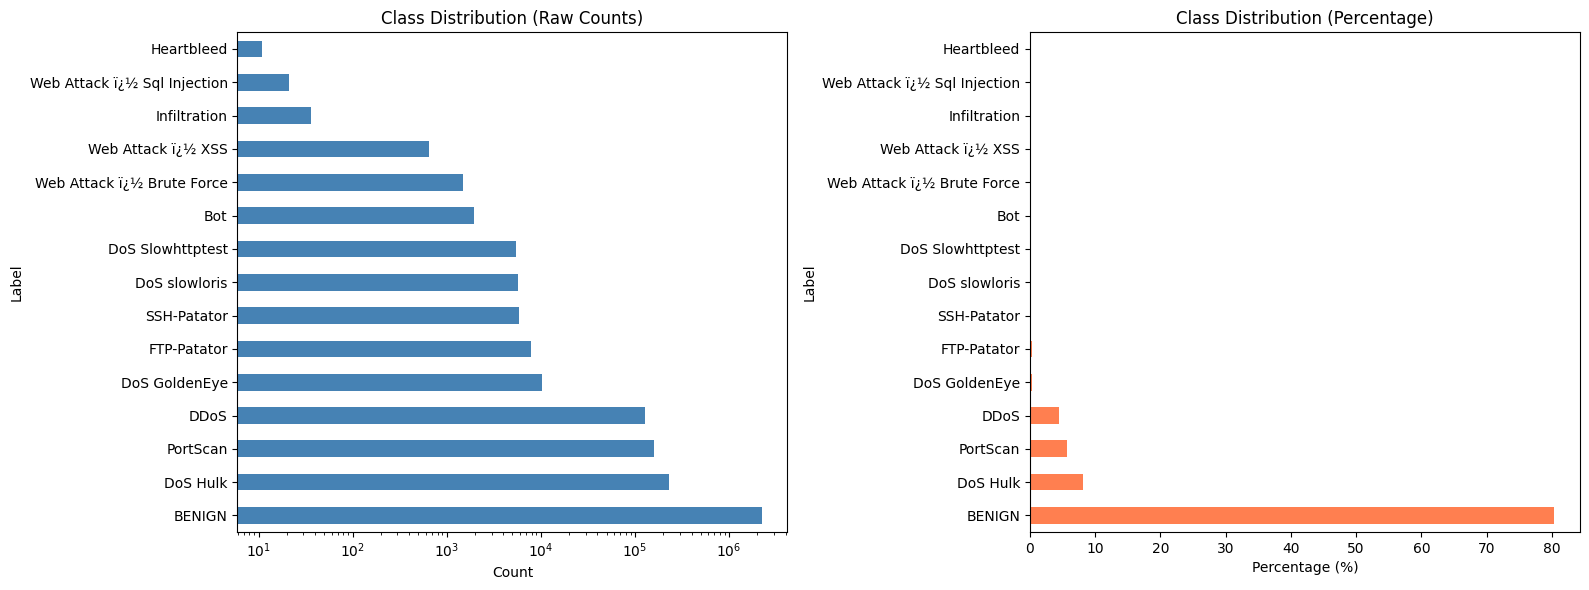


Rare attack types (< 0.1% of data):
  - Bot: 1,966 samples (0.0700%)
  - Web Attack ï¿½ Brute Force: 1,507 samples (0.0500%)
  - Web Attack ï¿½ XSS: 652 samples (0.0200%)
  - Infiltration: 36 samples (0.0000%)
  - Web Attack ï¿½ Sql Injection: 21 samples (0.0000%)
  - Heartbleed: 11 samples (0.0000%)


In [4]:
# Class distribution visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
class_counts = df['Label'].value_counts()
ax1 = axes[0]
class_counts.plot(kind='barh', ax=ax1, color='steelblue')
ax1.set_xlabel('Count')
ax1.set_title('Class Distribution (Raw Counts)')
ax1.set_xscale('log')  # Log scale due to extreme imbalance

# Percentages
ax2 = axes[1]
class_pct = (class_counts / len(df) * 100).round(2)
class_pct.plot(kind='barh', ax=ax2, color='coral')
ax2.set_xlabel('Percentage (%)')
ax2.set_title('Class Distribution (Percentage)')

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['output_dir'], 'class_distribution.png'), dpi=150)
plt.show()

# Identify rare classes (< 0.1% of data)
rare_threshold = 0.1
rare_classes = class_pct[class_pct < rare_threshold].index.tolist()
print(f"\nRare attack types (< {rare_threshold}% of data):")
for cls in rare_classes:
    print(f"  - {cls}: {class_counts[cls]:,} samples ({class_pct[cls]:.4f}%)")

### Why Multi-Class Instead of Per-Attack Binary Models?

> **Key Insight**: Per-attack binary models (BENIGN vs. single attack) create artificially small datasets for rare attacks like Heartbleed or Infiltration, leading to:
>
> 1. **Overfitting**: Models memorize the few examples instead of learning patterns
> 2. **Unstable metrics**: Accuracy becomes meaningless (predicting all BENIGN gets 99%+)
> 3. **Lost context**: Models can't distinguish between different attack types
>
> **Solution**: A unified multi-class model with proper class weighting handles all attacks together, learning shared patterns while still distinguishing attack types.

## 4. Preprocessing Pipeline

Steps:
1. Drop non-predictive columns (Flow ID, Timestamp, Source IP, Destination IP)
2. Handle infinite values
3. Drop columns with >50% missing values
4. Remove constant/near-constant columns
5. Impute remaining NaNs with median
6. Scale numeric features

In [5]:
def preprocess_data(df, label_col='Label'):
    """
    Preprocess CIC-IDS-2017 data.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Raw DataFrame
    label_col : str
        Name of label column
        
    Returns:
    --------
    X : pd.DataFrame
        Preprocessed features
    y : pd.Series
        Labels
    dropped_cols : list
        List of dropped column names
    """
    df = df.copy()
    dropped_cols = []
    
    # 1. Drop non-predictive columns
    # These columns either leak information or are not useful for prediction
    non_predictive = [
        'Flow ID',
        'Timestamp',
        'Source IP', 'Src IP',
        'Destination IP', 'Dst IP',
        'Source_File',  # Our tracking column
    ]
    
    for col in non_predictive:
        if col in df.columns:
            df = df.drop(columns=[col])
            dropped_cols.append(f"{col} (non-predictive)")
    
    print(f"Dropped {len(dropped_cols)} non-predictive columns")
    
    # 2. Separate features and labels
    y = df[label_col].copy()
    X = df.drop(columns=[label_col])
    
    # 3. Replace infinite values with NaN
    inf_count = np.isinf(X.select_dtypes(include=[np.number])).sum().sum()
    X = X.replace([np.inf, -np.inf], np.nan)
    print(f"Replaced {inf_count:,} infinite values with NaN")
    
    # 4. Drop columns with >50% missing
    missing_pct = X.isnull().mean()
    high_missing = missing_pct[missing_pct > 0.5].index.tolist()
    if high_missing:
        X = X.drop(columns=high_missing)
        dropped_cols.extend([f"{c} (>50% missing)" for c in high_missing])
        print(f"Dropped {len(high_missing)} columns with >50% missing values")
    
    # 5. Drop constant / near-constant columns (std = 0 or < 1e-10)
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    col_std = X[numeric_cols].std()
    constant_cols = col_std[col_std < 1e-10].index.tolist()
    if constant_cols:
        X = X.drop(columns=constant_cols)
        dropped_cols.extend([f"{c} (constant)" for c in constant_cols])
        print(f"Dropped {len(constant_cols)} constant columns")
    
    # 6. Convert object columns to numeric where possible (ports, etc.)
    for col in X.select_dtypes(include=['object']).columns:
        try:
            X[col] = pd.to_numeric(X[col], errors='coerce')
        except:
            # If conversion fails, drop the column
            X = X.drop(columns=[col])
            dropped_cols.append(f"{col} (non-numeric)")
    
    # 7. Drop rows where label is missing
    valid_mask = y.notna()
    X = X[valid_mask]
    y = y[valid_mask]
    
    print(f"\nFinal shape: {X.shape}")
    print(f"Remaining missing values: {X.isnull().sum().sum():,}")
    
    return X, y, dropped_cols

# Preprocess the data
X, y, dropped_cols = preprocess_data(df)

print(f"\nDropped columns summary:")
for col in dropped_cols[:10]:  # Show first 10
    print(f"  - {col}")
if len(dropped_cols) > 10:
    print(f"  ... and {len(dropped_cols) - 10} more")

Dropped 1 non-predictive columns
Replaced 4,376 infinite values with NaN
Dropped 8 constant columns

Final shape: (2830743, 70)
Remaining missing values: 5,734

Dropped columns summary:
  - Source_File (non-predictive)
  - Bwd PSH Flags (constant)
  - Bwd URG Flags (constant)
  - Fwd Avg Bytes/Bulk (constant)
  - Fwd Avg Packets/Bulk (constant)
  - Fwd Avg Bulk Rate (constant)
  - Bwd Avg Bytes/Bulk (constant)
  - Bwd Avg Packets/Bulk (constant)
  - Bwd Avg Bulk Rate (constant)


In [6]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Create label mapping for later reference
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label encoding:")
for label, code in sorted(label_mapping.items(), key=lambda x: x[1]):
    print(f"  {code}: {label}")

# Save label mapping
joblib.dump(label_encoder, os.path.join(CONFIG['output_dir'], 'label_encoder.joblib'))
print(f"\nLabel encoder saved to {CONFIG['output_dir']}/label_encoder.joblib")

Label encoding:
  0: BENIGN
  1: Bot
  2: DDoS
  3: DoS GoldenEye
  4: DoS Hulk
  5: DoS Slowhttptest
  6: DoS slowloris
  7: FTP-Patator
  8: Heartbleed
  9: Infiltration
  10: PortScan
  11: SSH-Patator
  12: Web Attack ï¿½ Brute Force
  13: Web Attack ï¿½ Sql Injection
  14: Web Attack ï¿½ XSS

Label encoder saved to outputs/label_encoder.joblib


## 5. Train/Validation/Test Split

We use **stratified splitting** to maintain class proportions across all sets. This is crucial for imbalanced datasets like CIC-IDS-2017.

> **Note on Time-Based Splitting**: Ideally, we would split by day (Monday data for training, Friday for testing) to simulate real deployment. However, this complicates stratification for rare attacks. The stratified approach here ensures all attack types appear in all splits.

In [7]:
# First split: separate test set (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_encoded,
    test_size=CONFIG['test_size'],
    random_state=RANDOM_STATE,
    stratify=y_encoded
)

# Second split: separate validation from training (15% of remaining ≈ 17.6%)
val_ratio = CONFIG['val_size'] / (1 - CONFIG['test_size'])
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=val_ratio,
    random_state=RANDOM_STATE,
    stratify=y_temp
)

print(f"Split sizes:")
print(f"  Training:   {len(X_train):>10,} ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Validation: {len(X_val):>10,} ({len(X_val)/len(X)*100:.1f}%)")
print(f"  Test:       {len(X_test):>10,} ({len(X_test)/len(X)*100:.1f}%)")
print(f"  Total:      {len(X):>10,}")

# Verify stratification
print(f"\nClass distribution verification (should be similar):")
train_dist = pd.Series(y_train).value_counts(normalize=True).sort_index()
test_dist = pd.Series(y_test).value_counts(normalize=True).sort_index()
print(f"  Max difference between train/test distributions: {(train_dist - test_dist).abs().max():.4f}")

Split sizes:
  Training:    1,981,519 (70.0%)
  Validation:    424,612 (15.0%)
  Test:          424,612 (15.0%)
  Total:       2,830,743

Class distribution verification (should be similar):
  Max difference between train/test distributions: 0.0000


In [8]:
# Create preprocessing pipeline (fit on training data only!)
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()

preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Fit on training data
X_train_scaled = preprocessor.fit_transform(X_train)
X_val_scaled = preprocessor.transform(X_val)
X_test_scaled = preprocessor.transform(X_test)

# Convert back to DataFrame for feature names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=numeric_features)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=numeric_features)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=numeric_features)

print(f"Preprocessing pipeline fitted on training data.")
print(f"Features shape after scaling: {X_train_scaled.shape}")

Preprocessing pipeline fitted on training data.
Features shape after scaling: (1981519, 70)


### Class Imbalance Strategy

> **Our Approach**: Instead of aggressively undersampling BENIGN (which loses valuable information), we use:
>
> 1. **`class_weight='balanced'`** in models: Automatically adjusts weights inversely proportional to class frequencies
> 2. **Stratified splits**: Ensures rare attacks appear in all train/val/test sets
> 3. **Macro-averaged metrics**: Gives equal weight to all classes regardless of size
>
> This approach is more robust than undersampling, which can remove important patterns from the majority class.

## 6. Feature Selection

We use a RandomForestClassifier with balanced class weights to estimate feature importance. This is more appropriate than RandomForestRegressor for classification tasks.

Steps:
1. Train a quick RF model on training data
2. Extract feature importances
3. Apply correlation filtering (remove redundant features)
4. Select top N features

In [9]:
def select_features(X_train, y_train, feature_names, n_features=30, corr_threshold=0.95):
    """
    Select top features using RandomForest importance with correlation filtering.
    
    Parameters:
    -----------
    X_train : np.ndarray or pd.DataFrame
        Training features
    y_train : np.ndarray
        Training labels
    feature_names : list
        List of feature names
    n_features : int
        Number of top features to select
    corr_threshold : float
        Threshold for correlation filtering
        
    Returns:
    --------
    selected_features : list
        Names of selected features
    importance_df : pd.DataFrame
        DataFrame with feature importances
    """
    print("Training RandomForest for feature importance estimation...")
    
    # Quick RF model for feature importance
    rf_selector = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,  # Limit depth for speed
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    
    rf_selector.fit(X_train, y_train)
    
    # Get feature importances
    importances = rf_selector.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print(f"Top 10 features by importance:")
    for i, row in importance_df.head(10).iterrows():
        print(f"  {row['Feature']}: {row['Importance']:.4f}")
    
    # Correlation filtering
    print(f"\nApplying correlation filtering (threshold: {corr_threshold})...")
    
    if isinstance(X_train, np.ndarray):
        X_train_df = pd.DataFrame(X_train, columns=feature_names)
    else:
        X_train_df = X_train
    
    # Calculate correlation matrix
    corr_matrix = X_train_df.corr().abs()
    
    # Find highly correlated pairs
    upper_tri = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
    
    # For each highly correlated pair, drop the one with lower importance
    importance_dict = dict(zip(importance_df['Feature'], importance_df['Importance']))
    to_drop = set()
    
    for col in upper_tri.columns:
        correlated_features = upper_tri.index[upper_tri[col] > corr_threshold].tolist()
        for feat in correlated_features:
            if importance_dict.get(col, 0) > importance_dict.get(feat, 0):
                to_drop.add(feat)
            else:
                to_drop.add(col)
    
    print(f"  Dropping {len(to_drop)} highly correlated features")
    
    # Filter importance DataFrame
    filtered_importance = importance_df[~importance_df['Feature'].isin(to_drop)]
    
    # Select top N features
    selected_features = filtered_importance.head(n_features)['Feature'].tolist()
    
    print(f"\nSelected {len(selected_features)} features")
    
    return selected_features, importance_df

# Perform feature selection
selected_features, importance_df = select_features(
    X_train_scaled,
    y_train,
    numeric_features,
    n_features=CONFIG['n_features']
)

Training RandomForest for feature importance estimation...
Top 10 features by importance:
  Destination Port: 0.0896
  Init_Win_bytes_backward: 0.0612
  min_seg_size_forward: 0.0327
  Fwd Packet Length Max: 0.0311
  Bwd Packet Length Mean: 0.0282
  Subflow Fwd Bytes: 0.0263
  Flow IAT Max: 0.0255
  Flow IAT Mean: 0.0241
  Subflow Bwd Bytes: 0.0241
  Total Length of Bwd Packets: 0.0240

Applying correlation filtering (threshold: 0.95)...
  Dropping 23 highly correlated features

Selected 30 features


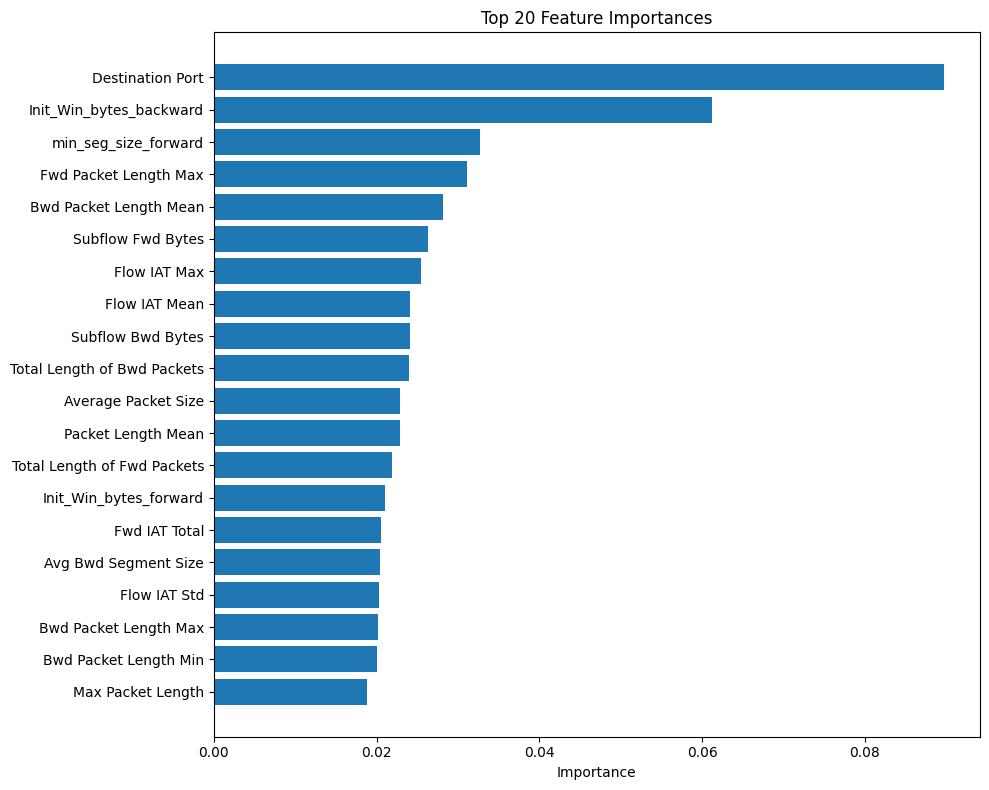

Selected features saved to outputs/selected_features.txt


In [11]:
# Visualize feature importances
fig, ax = plt.subplots(figsize=(10, 8))

top_features = importance_df.head(20)
ax.barh(range(len(top_features)), top_features['Importance'].values)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'].values)
ax.invert_yaxis()
ax.set_xlabel('Importance')
ax.set_title('Top 20 Feature Importances')

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['output_dir'], 'feature_importance.png'), dpi=150)
plt.show()

# Save selected features
with open(os.path.join(CONFIG['output_dir'], 'selected_features.txt'), 'w') as f:
    for feat in selected_features:
        f.write(f"{feat}\n")
print(f"Selected features saved to {CONFIG['output_dir']}/selected_features.txt")

In [12]:
# Reduce datasets to selected features
X_train_selected = X_train_scaled[selected_features]
X_val_selected = X_val_scaled[selected_features]
X_test_selected = X_test_scaled[selected_features]

print(f"Reduced feature set shapes:")
print(f"  Train: {X_train_selected.shape}")
print(f"  Val:   {X_val_selected.shape}")
print(f"  Test:  {X_test_selected.shape}")

Reduced feature set shapes:
  Train: (1981519, 30)
  Val:   (424612, 30)
  Test:  (424612, 30)


## 7. Model Training and Hyperparameter Tuning

We train three models:
1. **RandomForestClassifier**: Primary model with hyperparameter tuning
2. **LogisticRegression**: Linear baseline
3. **GaussianNB**: Simple probabilistic baseline

> **Why No QDA?**: Quadratic Discriminant Analysis assumes each class has its own covariance matrix. With highly correlated features (common in network traffic data), QDA produces singular covariance matrices, resulting in:
> - "Variables are collinear" warnings
> - Divide-by-zero errors
> - Unreliable predictions
>
> RandomForest and LogisticRegression are more robust to collinearity.

In [16]:
# Define models and their hyperparameter grids
models = {
    'RandomForest': {
        'model': RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1),
        'params': {
            'n_estimators': [100, 150],
            'max_depth': [10, 15, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
        },
        'tune': True  # <-- ADD THIS LINE
    },
    'LogisticRegression': {
        'model': LogisticRegression(
            class_weight='balanced',
            random_state=RANDOM_STATE,
            max_iter=1000,
            n_jobs=-1
        ),
        'params': {
            'C': [0.01, 0.1, 1.0, 10.0],
            'solver': ['lbfgs', 'saga'],
        },
        'tune': True
    },
    'NaiveBayes': {
        'model': GaussianNB(),
        'params': {},
        'tune': False
    }
}

print(f"Models to train: {list(models.keys())}")

Models to train: ['RandomForest', 'LogisticRegression', 'NaiveBayes']


In [17]:
def train_and_evaluate_model(name, model_config, X_train, y_train, X_val, y_val):
    """
    Train a model with optional hyperparameter tuning.
    
    Returns:
    --------
    model : trained model
    results : dict with metrics
    """
    print(f"\n{'='*50}")
    print(f"Training {name}...")
    print(f"{'='*50}")
    
    model = model_config['model']
    
    if model_config['tune'] and model_config['params']:
        print(f"Running RandomizedSearchCV ({CONFIG['n_iter_search']} iterations, {CONFIG['cv_folds']}-fold CV)...")
        
        cv = StratifiedKFold(n_splits=CONFIG['cv_folds'], shuffle=True, random_state=RANDOM_STATE)
        
        search = RandomizedSearchCV(
            model,
            model_config['params'],
            n_iter=CONFIG['n_iter_search'],
            cv=cv,
            scoring='f1_macro',  # Use macro F1 for imbalanced data
            n_jobs=-1,
            random_state=RANDOM_STATE,
            verbose=1
        )
        
        search.fit(X_train, y_train)
        model = search.best_estimator_
        print(f"\nBest parameters: {search.best_params_}")
        print(f"Best CV score (macro F1): {search.best_score_:.4f}")
    else:
        model.fit(X_train, y_train)
    
    # Evaluate on train and validation sets
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    results = {
        'model_name': name,
        'train_accuracy': accuracy_score(y_train, y_train_pred),
        'val_accuracy': accuracy_score(y_val, y_val_pred),
        'train_f1_macro': f1_score(y_train, y_train_pred, average='macro'),
        'val_f1_macro': f1_score(y_val, y_val_pred, average='macro'),
        'train_f1_weighted': f1_score(y_train, y_train_pred, average='weighted'),
        'val_f1_weighted': f1_score(y_val, y_val_pred, average='weighted'),
    }
    
    print(f"\nResults:")
    print(f"  Train Accuracy: {results['train_accuracy']:.4f}")
    print(f"  Val Accuracy:   {results['val_accuracy']:.4f}")
    print(f"  Train F1 (macro): {results['train_f1_macro']:.4f}")
    print(f"  Val F1 (macro):   {results['val_f1_macro']:.4f}")
    
    # Check for overfitting
    overfit_gap = results['train_accuracy'] - results['val_accuracy']
    if overfit_gap > 0.05:
        print(f"  ⚠️  Potential overfitting detected (train-val gap: {overfit_gap:.4f})")
    
    return model, results

# Train all models
trained_models = {}
all_results = []

for name, config in models.items():
    model, results = train_and_evaluate_model(
        name, config,
        X_train_selected, y_train,
        X_val_selected, y_val
    )
    trained_models[name] = model
    all_results.append(results)


Training RandomForest...
Running RandomizedSearchCV (5 iterations, 3-fold CV)...
Fitting 3 folds for each of 5 candidates, totalling 15 fits

Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20}
Best CV score (macro F1): 0.8297

Results:
  Train Accuracy: 0.9965
  Val Accuracy:   0.9963
  Train F1 (macro): 0.9267
  Val F1 (macro):   0.8634

Training LogisticRegression...
Running RandomizedSearchCV (5 iterations, 3-fold CV)...
Fitting 3 folds for each of 5 candidates, totalling 15 fits

Best parameters: {'solver': 'lbfgs', 'C': 0.1}
Best CV score (macro F1): 0.3871

Results:
  Train Accuracy: 0.7748
  Val Accuracy:   0.7743
  Train F1 (macro): 0.3892
  Val F1 (macro):   0.3871

Training NaiveBayes...

Results:
  Train Accuracy: 0.6790
  Val Accuracy:   0.6791
  Train F1 (macro): 0.4660
  Val F1 (macro):   0.4428


In [18]:
# Summary table of model performance
results_df = pd.DataFrame(all_results)
print("\nModel Comparison (Validation Set):")
print(results_df[['model_name', 'val_accuracy', 'val_f1_macro', 'val_f1_weighted']].to_string(index=False))


Model Comparison (Validation Set):
        model_name  val_accuracy  val_f1_macro  val_f1_weighted
      RandomForest      0.996319      0.863423         0.997154
LogisticRegression      0.774340      0.387087         0.840742
        NaiveBayes      0.679112      0.442797         0.790702


## 8. Comprehensive Evaluation

Evaluate the best model on the held-out test set with:
- Per-class precision, recall, F1-score
- Confusion matrix
- ROC-AUC (macro-averaged)

In [19]:
# Select best model based on validation F1 (macro)
best_model_name = results_df.loc[results_df['val_f1_macro'].idxmax(), 'model_name']
best_model = trained_models[best_model_name]

print(f"Best model: {best_model_name}")
print(f"Validation F1 (macro): {results_df.loc[results_df['val_f1_macro'].idxmax(), 'val_f1_macro']:.4f}")

Best model: RandomForest
Validation F1 (macro): 0.8634


In [20]:
# Evaluate on test set
y_test_pred = best_model.predict(X_test_selected)

# Overall metrics
test_metrics = {
    'Accuracy': accuracy_score(y_test, y_test_pred),
    'Precision (macro)': precision_score(y_test, y_test_pred, average='macro', zero_division=0),
    'Recall (macro)': recall_score(y_test, y_test_pred, average='macro', zero_division=0),
    'F1 (macro)': f1_score(y_test, y_test_pred, average='macro', zero_division=0),
    'F1 (weighted)': f1_score(y_test, y_test_pred, average='weighted', zero_division=0),
}

print(f"\n{'='*50}")
print(f"TEST SET RESULTS - {best_model_name}")
print(f"{'='*50}")
for metric, value in test_metrics.items():
    print(f"  {metric}: {value:.4f}")


TEST SET RESULTS - RandomForest
  Accuracy: 0.9964
  Precision (macro): 0.8945
  Recall (macro): 0.9078
  F1 (macro): 0.8710
  F1 (weighted): 0.9972


In [21]:
# Per-class metrics
class_names = label_encoder.classes_

print(f"\n\nPer-Class Classification Report:")
print("="*80)
report = classification_report(
    y_test, y_test_pred,
    target_names=class_names,
    zero_division=0,
    output_dict=True
)

# Convert to DataFrame for cleaner display
report_df = pd.DataFrame(report).transpose()
report_df = report_df.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')
report_df = report_df.round(4)

# Sort by F1-score
report_df = report_df.sort_values('f1-score', ascending=False)
print(report_df.to_string())



Per-Class Classification Report:
                              precision  recall  f1-score   support
Heartbleed                       1.0000  1.0000    1.0000       2.0
Infiltration                     1.0000  1.0000    1.0000       5.0
SSH-Patator                      1.0000  1.0000    1.0000     885.0
DDoS                             0.9997  0.9996    0.9997   19204.0
FTP-Patator                      1.0000  0.9992    0.9996    1191.0
BENIGN                           0.9999  0.9960    0.9979  340965.0
DoS slowloris                    0.9988  0.9965    0.9977     869.0
DoS Hulk                         0.9946  0.9998    0.9972   34661.0
PortScan                         0.9943  0.9997    0.9970   23839.0
DoS GoldenEye                    0.9955  0.9968    0.9961    1544.0
DoS Slowhttptest                 0.9928  0.9964    0.9946     825.0
Web Attack ï¿½ Brute Force       0.8167  0.6504    0.7241     226.0
Web Attack ï¿½ Sql Injection     1.0000  0.3333    0.5000       3.0
Web Attack ï¿

In [22]:
# Highlight rare attack performance
print("\n\nRare Attack Type Performance:")
print("="*60)
print("(These are attack types with < 0.1% representation in the data)")
print()

# Get rare classes from earlier analysis
rare_report = report_df[report_df.index.isin(rare_classes)] if rare_classes else pd.DataFrame()

if len(rare_report) > 0:
    print(rare_report[['precision', 'recall', 'f1-score', 'support']].to_string())
else:
    print("No rare attack types identified.")
    
# Show attacks with low recall (missed attacks are critical!)
print("\n\nAttack Types with Low Recall (< 0.5):")
print("="*60)
print("(Low recall means many attacks are being missed!)")
print()
low_recall = report_df[report_df['recall'] < 0.5]
if len(low_recall) > 0:
    print(low_recall[['precision', 'recall', 'f1-score', 'support']].to_string())
else:
    print("All attack types have recall >= 0.5")



Rare Attack Type Performance:
(These are attack types with < 0.1% representation in the data)

                              precision  recall  f1-score  support
Heartbleed                       1.0000  1.0000    1.0000      2.0
Infiltration                     1.0000  1.0000    1.0000      5.0
Web Attack ï¿½ Brute Force       0.8167  0.6504    0.7241    226.0
Web Attack ï¿½ Sql Injection     1.0000  0.3333    0.5000      3.0
Web Attack ï¿½ XSS               0.4051  0.6531    0.5000     98.0
Bot                              0.2207  0.9966    0.3614    295.0


Attack Types with Low Recall (< 0.5):
(Low recall means many attacks are being missed!)

                              precision  recall  f1-score  support
Web Attack ï¿½ Sql Injection        1.0  0.3333       0.5      3.0


### Why Accuracy Alone Is Insufficient

> **Critical Insight**: With 80%+ BENIGN traffic, a model that simply predicts "BENIGN" for everything would achieve >80% accuracy!
>
> This is why we focus on:
> - **Macro F1-score**: Gives equal weight to all classes, so rare attacks matter as much as BENIGN
> - **Per-class Recall**: Shows what percentage of each attack type we actually detect
> - **Confusion Matrix**: Reveals which attacks are being confused with each other

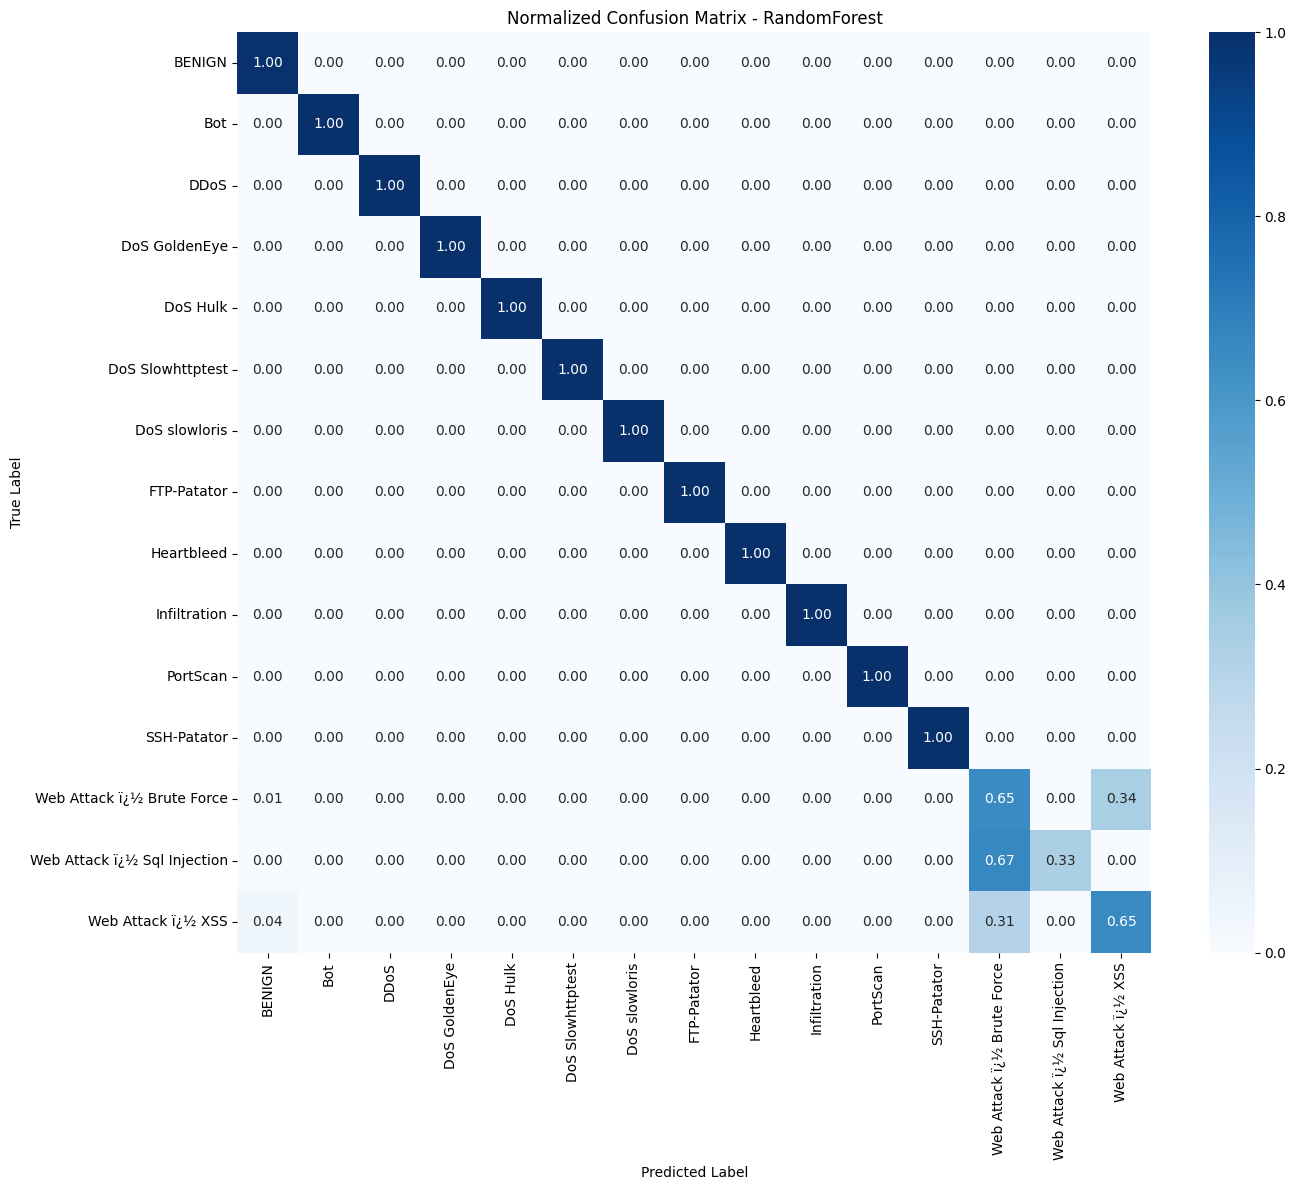

In [23]:
# Confusion Matrix
fig, ax = plt.subplots(figsize=(14, 12))

cm = confusion_matrix(y_test, y_test_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    ax=ax
)

ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title(f'Normalized Confusion Matrix - {best_model_name}')

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['output_dir'], 'confusion_matrix.png'), dpi=150)
plt.show()

In [24]:
# ROC-AUC (macro-averaged)
# Only if model supports predict_proba
if hasattr(best_model, 'predict_proba'):
    try:
        y_test_proba = best_model.predict_proba(X_test_selected)
        
        # One-vs-rest ROC-AUC
        roc_auc_macro = roc_auc_score(
            y_test, y_test_proba,
            multi_class='ovr',
            average='macro'
        )
        roc_auc_weighted = roc_auc_score(
            y_test, y_test_proba,
            multi_class='ovr',
            average='weighted'
        )
        
        print(f"\nROC-AUC Scores:")
        print(f"  Macro-averaged:    {roc_auc_macro:.4f}")
        print(f"  Weighted-averaged: {roc_auc_weighted:.4f}")
    except Exception as e:
        print(f"Could not compute ROC-AUC: {e}")
else:
    print("Model does not support probability predictions for ROC-AUC.")


ROC-AUC Scores:
  Macro-averaged:    0.9998
  Weighted-averaged: 0.9999


## 9. Export Artifacts and Summary

In [25]:
# Save the best trained model
model_path = os.path.join(CONFIG['output_dir'], f'best_model_{best_model_name.lower()}.joblib')
joblib.dump(best_model, model_path)
print(f"Model saved to: {model_path}")

# Save the preprocessor pipeline
preprocessor_path = os.path.join(CONFIG['output_dir'], 'preprocessor.joblib')
joblib.dump(preprocessor, preprocessor_path)
print(f"Preprocessor saved to: {preprocessor_path}")

# Save the complete classification report
report_path = os.path.join(CONFIG['output_dir'], 'classification_report.csv')
report_df.to_csv(report_path)
print(f"Classification report saved to: {report_path}")

Model saved to: outputs/best_model_randomforest.joblib
Preprocessor saved to: outputs/preprocessor.joblib
Classification report saved to: outputs/classification_report.csv


In [26]:
# Final Summary
print("\n" + "="*70)
print("                       FINAL SUMMARY")
print("="*70)

print(f"\n📊 Dataset:")
print(f"   Total samples: {len(X):,}")
print(f"   Classes: {len(class_names)}")
print(f"   Features (selected): {len(selected_features)}")

print(f"\n🏆 Best Model: {best_model_name}")

print(f"\n📈 Test Set Performance:")
print(f"   Accuracy:      {test_metrics['Accuracy']:.4f}")
print(f"   F1 (macro):    {test_metrics['F1 (macro)']:.4f}")
print(f"   F1 (weighted): {test_metrics['F1 (weighted)']:.4f}")

print(f"\n📁 Saved Artifacts:")
print(f"   - {model_path}")
print(f"   - {preprocessor_path}")
print(f"   - {CONFIG['output_dir']}/label_encoder.joblib")
print(f"   - {CONFIG['output_dir']}/selected_features.txt")
print(f"   - {CONFIG['output_dir']}/classification_report.csv")
print(f"   - {CONFIG['output_dir']}/confusion_matrix.png")
print(f"   - {CONFIG['output_dir']}/feature_importance.png")
print(f"   - {CONFIG['output_dir']}/class_distribution.png")

print("\n" + "="*70)
print("                     PIPELINE COMPLETE")
print("="*70)


                       FINAL SUMMARY

📊 Dataset:
   Total samples: 2,830,743
   Classes: 15
   Features (selected): 30

🏆 Best Model: RandomForest

📈 Test Set Performance:
   Accuracy:      0.9964
   F1 (macro):    0.8710
   F1 (weighted): 0.9972

📁 Saved Artifacts:
   - outputs/best_model_randomforest.joblib
   - outputs/preprocessor.joblib
   - outputs/label_encoder.joblib
   - outputs/selected_features.txt
   - outputs/classification_report.csv
   - outputs/confusion_matrix.png
   - outputs/feature_importance.png
   - outputs/class_distribution.png

                     PIPELINE COMPLETE


In [27]:
# Per-class F1 summary table (for research report)
print("\n\nPer-Class F1-Score Summary Table (for Research Report):")
print("="*60)

f1_summary = report_df[['f1-score', 'support']].copy()
f1_summary.columns = ['F1-Score', 'Test Samples']
f1_summary['Test Samples'] = f1_summary['Test Samples'].astype(int)
f1_summary = f1_summary.sort_values('F1-Score', ascending=False)

print(f1_summary.to_string())

print(f"\nMacro-averaged F1-Score: {test_metrics['F1 (macro)']:.4f}")
print(f"Weighted-averaged F1-Score: {test_metrics['F1 (weighted)']:.4f}")



Per-Class F1-Score Summary Table (for Research Report):
                              F1-Score  Test Samples
Heartbleed                      1.0000             2
Infiltration                    1.0000             5
SSH-Patator                     1.0000           885
DDoS                            0.9997         19204
FTP-Patator                     0.9996          1191
BENIGN                          0.9979        340965
DoS slowloris                   0.9977           869
DoS Hulk                        0.9972         34661
PortScan                        0.9970         23839
DoS GoldenEye                   0.9961          1544
DoS Slowhttptest                0.9946           825
Web Attack ï¿½ Brute Force      0.7241           226
Web Attack ï¿½ Sql Injection    0.5000             3
Web Attack ï¿½ XSS              0.5000            98
Bot                             0.3614           295

Macro-averaged F1-Score: 0.8710
Weighted-averaged F1-Score: 0.9972
